# Определение стоимости автомобилей (Auto_Sale)

<h2>Содержание<span class="tocSkip"></span></h2> 
<br>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Общие выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.
____

**Описание данных:** В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Признаки:** 

* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **RegistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **Repaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

**Целевой признак:** 

* **Price** — цена (евро)
____

**Задача:** Нужно построить модель для определения стоимости. 
____

**Цель:** С помощью модели определить стоимость автомобиля, исходя из следующих важных для Заказчика критериев:
- качество предсказания;
- скорость предсказания;
- время обучения.
____

## Подготовка данных

In [1]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit

import pandas as pd

import catboost
import phik
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import (LinearRegression, 
                                  Ridge, 
                                  Lasso,
                                  ElasticNet)
from catboost import CatBoostRegressor
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix,
                             accuracy_score,
                             make_scorer)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats as st

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [3]:
#Загружаем файлы с данными
try:
    data = pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 11. Численные методы/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [4]:
#Проверяем датафрейм
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

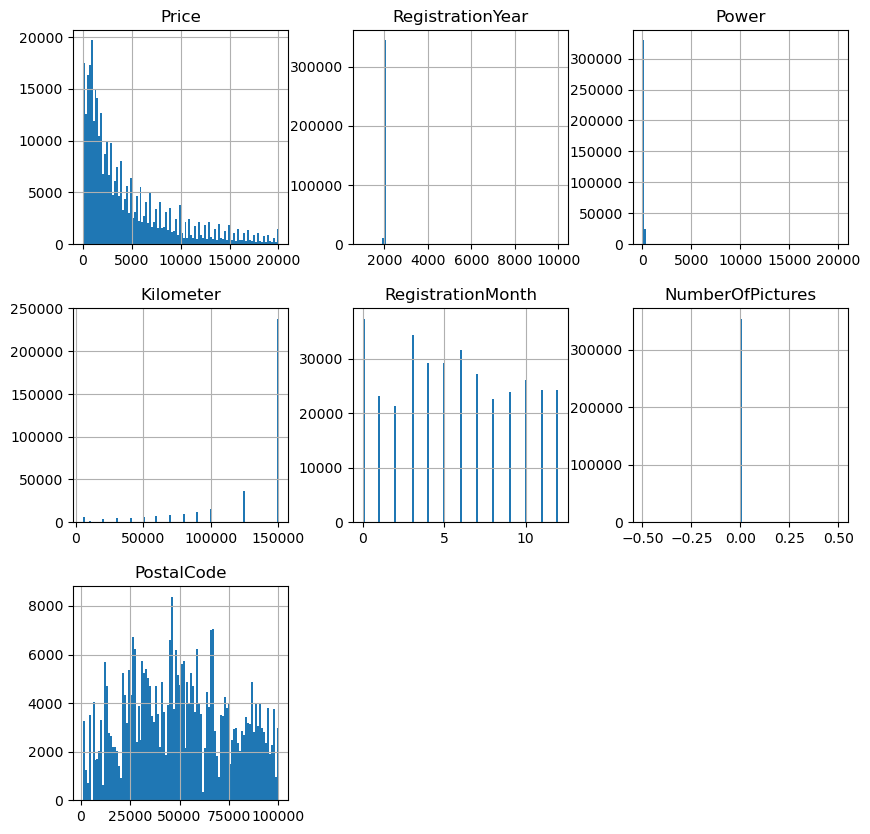

In [5]:
#Выведем информацию о каждом датафрейме и гистограммы
data.info();
data.hist(figsize=(10,10), bins=100);

In [6]:
#Выведем описание датафрейма
data.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.657,4514.159,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234,90.228,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094,189.850,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.173,37905.342,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.715,3.726,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689,25783.096,1067.0,30165.0,49413.0,71083.0,99998.0


In [7]:
#Посмотрим, какая последня дата скачивания анкеты, чтобы понять текущую дату выгрузки
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data.sort_values('DateCrawled', ascending=False).head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
90713,2016-04-07 14:36:58,3500,sedan,1999,manual,143,e_klasse,150000,8,gasoline,mercedes_benz,no,2016-04-07 00:00:00,0,64846,2016-04-07 14:36:58
339649,2016-04-07 14:36:56,8650,suv,1992,manual,121,wrangler,125000,5,petrol,jeep,no,2016-04-07 00:00:00,0,20357,2016-04-07 14:36:56
301030,2016-04-07 14:36:55,15200,wagon,2008,manual,190,a6,150000,9,gasoline,audi,no,2016-04-07 00:00:00,0,81476,2016-04-07 14:36:55
53739,2016-04-07 14:36:54,400,small,1996,manual,60,ibiza,150000,0,NaN,seat,NaN,2016-04-07 00:00:00,0,66299,2016-04-07 14:36:54
204218,2016-04-07 14:36:53,6990,coupe,1979,auto,143,3er,150000,6,petrol,bmw,no,2016-04-07 00:00:00,0,71336,2016-04-07 14:36:53


Сразу же удалим признаки, которые нам не потребуется:
* **RegistrationMonth** - года регистрации будет вполне достаточно;
* **DateCrawled, DateCreated, LastSeen** - все даты, связанные с созданием объявлений и активностями пользователей, лишние
* **PostalCode** - слишком индивидуальная информация о владельце, был бы хотя бы населенный пункт
* **NumberOfPictures** - везде нули, это странно, но что имеем, то имеем

In [8]:
#Удаляем ненужные признаки
useless_features = ['RegistrationMonth', 
                    'DateCrawled', 
                    'DateCreated', 
                    'LastSeen', 
                    'PostalCode', 
                    'NumberOfPictures']

new_columns = []
for i in data.columns:
    if i not in useless_features:
        new_columns.append(i)
        
data_new = data[new_columns]

In [9]:
#Посмотрим, какие есть значения для категориальных признаков
category_features = []
for i in data_new.columns:
    if i not in data_new.describe().columns:
        category_features.append(i)
        print(i)
        print(data_new[i].unique())
        print('')

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Gearbox
['manual' 'auto' nan]

Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuor

Можно сделать следующие выводы по небольшому анализу данных:
* Пропущенные значения есть в **VehicleType, Gearbox, Model, FuelType, Repaired**
* Выбросы есть в **RegistrationYear, Power**

Отработаем выбросы. В случае с **RegistrationYear** значения мало вероятно могут быть больше 2023 и меньше 1950 (совсем невероятный раритет). Посмотрим, сколько их и какие они.

In [10]:
#Отфильтруем таблицу по году регистрации
print(data_new.loc[(data_new['RegistrationYear'] > 2023) | (data_new['RegistrationYear'] < 1950), 'RegistrationYear'].count())

351


Всего 351 шт. вылетов, смело удалим их.

In [11]:
#Удаляем выбросы по году регистрации
data_new_1 = data_new.loc[(data_new['RegistrationYear'] <= 2016) & (data_new['RegistrationYear'] >= 1950)]
data_new_1.shape

(339593, 10)

В случае с **Power** большое количество значений с 0. Для замены необходимо отталкиваться от марки и модели авто. А для значений нереально высоких поставим ограничение 1100 л.с. 

In [12]:
#Посмотрим, сколько значений больше 1100 в Power
data_new_1.loc[data['Power'] > 1100, 'Power'].count()

248

In [13]:
#Смело их удаляем, их очень мало
data_new_1 = data_new_1.loc[data_new_1['Power'] <= 1100]
data_new_1.shape

(339345, 10)

Теперь заменяем нулевые значения.

In [14]:
#Прибавим признаки Model и Brand друг к другу 
data_new_1['Model_Brand'] = data_new_1['Model'] + data_new_1['Brand']
data_new_1['Model_Brand'].head()

0    golfvolkswagen
1               NaN
2         grandjeep
3    golfvolkswagen
4        fabiaskoda
Name: Model_Brand, dtype: object

In [15]:
#Теперь отфильтруем, чтобы не было нулей и сделаем большую сводную таблицу
data_new_1.loc[data_new_1['Power'] > 0].groupby('Model_Brand')['Power'].mean().head()

Model_Brand
100audi          137.345646
145alfa_romeo    111.972222
147alfa_romeo    120.656746
156alfa_romeo    150.904085
159alfa_romeo    173.196970
Name: Power, dtype: float64

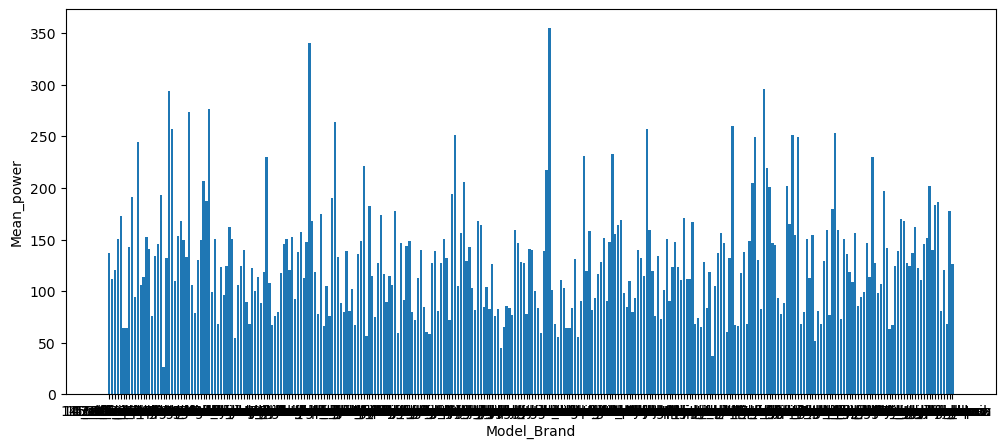

In [16]:
#Построим столбчатую диаграмму для каждой категории
plt.figure(figsize=(12,5)); 
plt.bar(data_new_1.loc[data_new_1['Power'] > 0].groupby('Model_Brand')['Power'].mean().index, 
        data_new_1.loc[data_new_1['Power'] > 0].groupby('Model_Brand')['Power'].mean(), 
        width=0.8);
plt.xlabel('Model_Brand');
plt.ylabel('Mean_power');

Но так как размер выборки позволяет, лучше удалим все нулевые значения.

In [17]:
data_new_1.loc[data_new_1['Power'] == 0, 'Power'].count()

36326

In [18]:
#Удалим данные нулевые значения, т.к. лучше их не менять
data_new_1 = data_new_1.loc[data_new_1['Power'] > 0]
data_new_1.shape

(303019, 11)

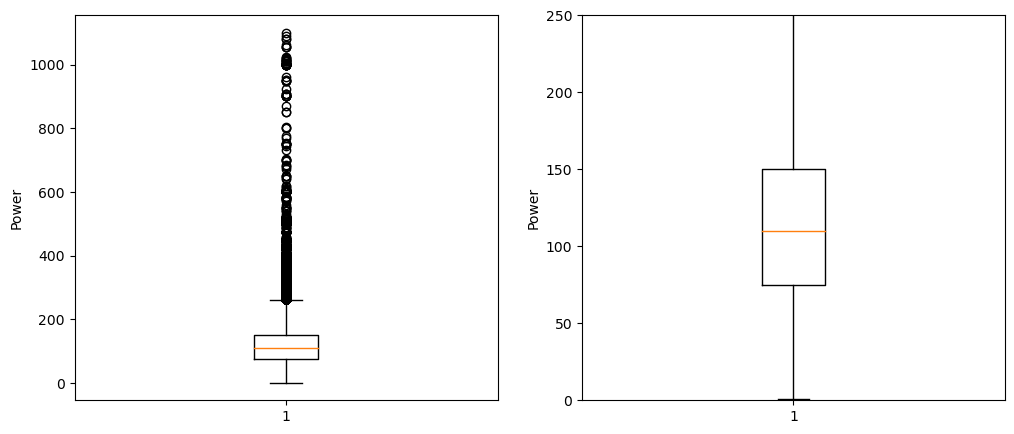

In [19]:
#Посмотрим на диаграмму с усами для Power
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize=(12,5))

plt.subplot(121)
plt.boxplot(data_new_1['Power']);
plt.ylabel('Power');

plt.subplot(122)
plt.boxplot(data_new_1['Power']);
plt.ylim([0, 250]);
plt.ylabel('Power');

In [20]:
#Уберем значения, которые меньше 60, т.к. в подавляющем большистве мощность автомобилей больше
data_new_1 = data_new_1.loc[data_new_1['Power'] > 40]
data_new_1.shape

(301356, 11)

В случае с **Gearbox** и **FuelType** можно попробовать проследить, до какого года были машины только на ручной коробке и, допустим, на бензине.  

In [21]:
#Заменим все пропущенные значения в категориальных признаках VehicleType, Model, FuelType и Gearbox на unknown
for i in ['VehicleType', 'Model', 'FuelType', 'Gearbox']:
    data_new_1.loc[data[i].isna() == True, i] = 'unknown'

data_new_1.shape

(301356, 11)

Рассмотрим признак Repaired. Можно применить логику, что если машина в цене меньше, чем самая дешевая без ремонта, то она практически точно отремонтирована.  

In [22]:
print(f'Пустых значений до замены в Repaired:', data_new_1.loc[data_new_1['Repaired'].isna() == True, 'Repaired'].shape)

for i in data_new_1['Model_Brand'].unique():
    min_price = data_new_1.loc[(data_new_1['Model_Brand'] == i) 
                               & (data_new_1['Repaired'] == 'no'), 'Price'].min()
    data_new_1.loc[(data_new_1['Model_Brand'] == i)
                   & (data_new_1['Price'] < min_price)
                   & (data_new_1['Repaired'].isna() == True), 'Repaired'] = 'yes'

print(f'Пустых значений после замены в Repaired:', data_new_1.loc[data_new_1['Repaired'].isna() == True, 'Repaired'].shape)

Пустых значений до замены в Repaired: (44850,)
Пустых значений после замены в Repaired: (44725,)


Удалось поменять не так много значений, но зато мы в этой замене праткически полностью уверены. Остальные значения просто меняем на **yes** по той логике, что если человек не указал про ремонт, то она точно битая. 

In [23]:
#Удаляем строки с пропущенными значениями в признаке Repaired
data_new_1.loc[data['Repaired'].isna() == True, 'Repaired'] = 'yes'
data_new_1.shape

(301356, 11)

In [24]:
#Удалим нулевые значения из Price
data_new_1 = data_new_1.loc[data_new_1['Price'] > 0]
data_new_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295034 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295034 non-null  int64 
 1   VehicleType       295034 non-null  object
 2   RegistrationYear  295034 non-null  int64 
 3   Gearbox           295034 non-null  object
 4   Power             295034 non-null  int64 
 5   Model             295034 non-null  object
 6   Kilometer         295034 non-null  int64 
 7   FuelType          295034 non-null  object
 8   Brand             295034 non-null  object
 9   Repaired          295034 non-null  object
 10  Model_Brand       284148 non-null  object
dtypes: int64(4), object(7)
memory usage: 27.0+ MB


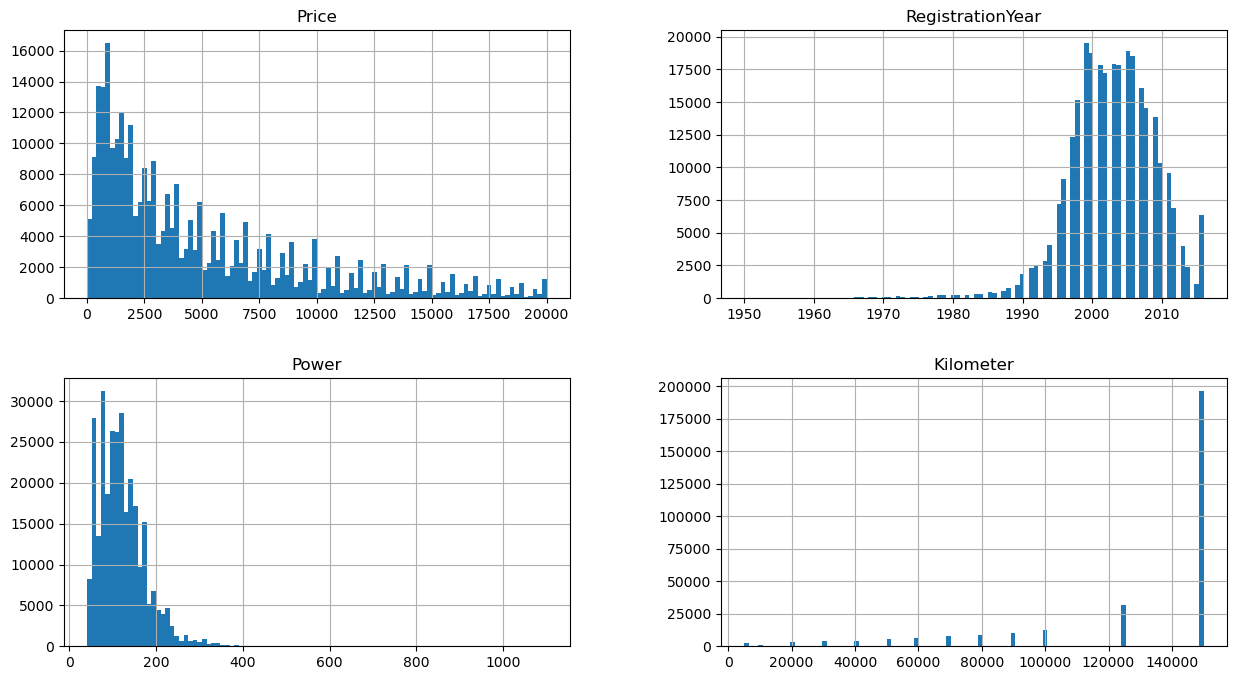

In [25]:
#Создадим итоговый датафрейм, с которым впоследствии будем работать
data_finish = data_new_1.drop('Model_Brand', axis=1)
data_finish.hist(figsize=(15,8), bins=100);

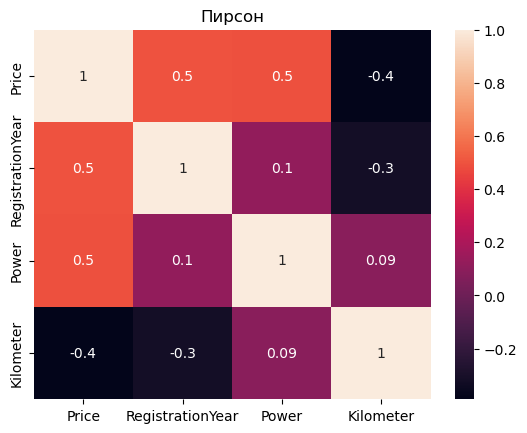

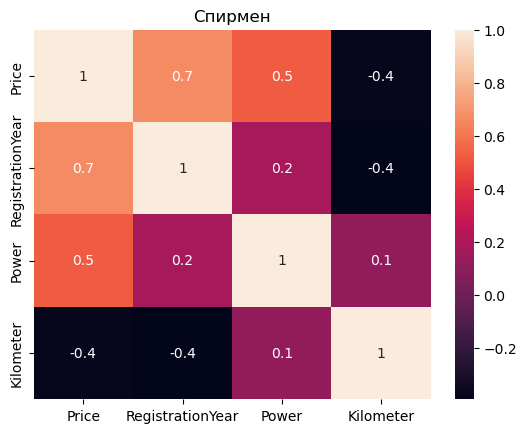

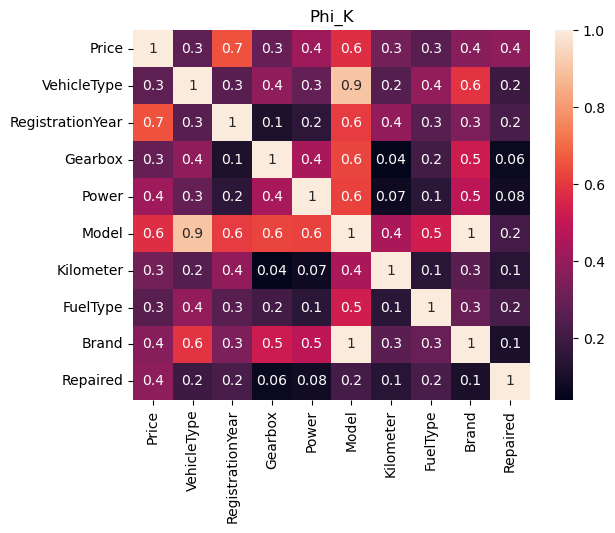

In [26]:
#Выведем тепловую карту, чтобы понять, какие параметры наибольшим образом коррелируют между собой
plt.figure()
plt.title('Пирсон')
sns.heatmap(data_finish.corr(method='pearson'), annot=True, fmt='.1g');
plt.figure()
plt.title('Спирмен')
sns.heatmap(data_finish.corr(method='spearman'), annot=True, fmt='.1g');

#Выделим некатегориальные признаки в отдельный список
int_list = list(data_finish.select_dtypes(exclude=['object']).columns)

#Используем phik
plt.figure()
plt.title('Phi_K')
sns.heatmap(data_finish.phik_matrix(int_list), annot=True, fmt='.1g');

In [27]:
#Выведем теперь параметр VIF для поиска коллинеарных признаков 
vif_data = pd.DataFrame()
vif_data['feature'] = data_finish[int_list].columns
vif_data['VIF'] = [variance_inflation_factor(data_finish[int_list].values, i) for i in range(len(data_finish[int_list].columns))]
vif_data.round(3)

,feature,VIF
0,Price,3.745
1,RegistrationYear,20.498
2,Power,8.784
3,Kilometer,17.985


Можно сделать вывод, что наша прогнозная переменная **Price** обладает умеренной корреляцией, а все сотальные числовые переменные достаточно сильно коллинеарны, особенно между собой **Год регистрации** и **Пробег**. Но так как нас интересует **Price**, то смысла бороться с коллинеарностью нету. Тем более мультиколлениарность сильно влияет в основном на регрессионные модели (особенно линейную), а в данном проекте будут использованы в основном бустинговые модели и модели деревьев.

**Выводы:**

1) Вылеты устранены, пропущенные значения заполнены или удалены;\
2) На цену в большей степени влияет год регистрации и модель.

## Обучение моделей

In [28]:
#Разделим данные на выборки 80:20, так как в дальнейшей будем применена кросс-валидация (80 станет 60:20)
features = data_finish.drop('Price', axis=1)
target = data_finish['Price']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(236027, 9)
(236027,)
(59007, 9)
(59007,)


Применим метод OHE к категориальным данным для преобразования категориальных признаков в числовые

In [29]:
columns_ohe = []
for i in data_finish.columns:
    if i not in data_finish.describe().columns:
        columns_ohe.append(i)
print(columns_ohe)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [30]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[columns_ohe])

features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[columns_ohe])
features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohe[columns_ohe])

features_train_ohe = features_train_ohe.drop(columns_ohe, axis=1)
features_test_ohe = features_test_ohe.drop(columns_ohe, axis=1)

features_train_ohe.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
198950,2002,107,150000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274027,2002,90,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
267207,1992,196,30000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
320703,1999,122,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3331,2011,170,80000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Применим также метод OrdinalEncoder к категориальным данным для преобразования категориальных признаков в числовые

In [31]:
encoder_ord = OrdinalEncoder()
encoder_ord.fit(features_train[columns_ohe])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[encoder_ord.get_feature_names_out()] = encoder_ord.transform(features_train_ord[columns_ohe])
features_test_ord[encoder_ord.get_feature_names_out()] = encoder_ord.transform(features_test_ord[columns_ohe])

features_train_ord.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
198950,5.0,2002,1.0,107,75.0,150000,6.0,27.0,0.0
274027,4.0,2002,1.0,90,163.0,150000,2.0,31.0,0.0
267207,4.0,1992,1.0,196,116.0,30000,6.0,38.0,1.0
320703,0.0,1999,1.0,122,233.0,150000,2.0,20.0,0.0
3331,4.0,2011,0.0,170,116.0,80000,2.0,38.0,0.0


Используем для сравнения 5 моделей: LightGBM, Catboost, RandomForestRegressor, LinearRegression, DecisionTreeRegressor

In [32]:
#Добавим новую метрику rmse
def rmse_score(target, predictions):
    score = mean_squared_error(target, predictions) ** 0.5
    return score

rmse = make_scorer(rmse_score, greater_is_better = False)

In [33]:
best_score_set = []

In [34]:
#Используем LightGBM вместе с RandomizedSearchCV
LGBM = lgb.LGBMRegressor(verbose=-1, n_jobs=-1, random_state=12345)

rs_space={'max_depth':([None] + [i for i in range(2, 7)]),
          'n_estimators':np.arange(10, 500, 50),
         }

LGBM_random = RandomizedSearchCV(LGBM, rs_space, n_iter=100, scoring=rmse, cv=3)
model_random = LGBM_random.fit(features_train_ord, target_train)

best_model_LightGBM = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для LGBM:')
print('Лучшая модель:', best_model_LightGBM)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший RMSE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для LGBM:
Лучшая модель: LGBMRegressor(max_depth=None, n_estimators=460, random_state=12345, verbose=-1)
Лучшие гиперпараметры: {'n_estimators': 460, 'max_depth': None}
Лучший RMSE: 1596.26


In [36]:
#Используем Catboost вместе с RandomizedSearchCV
catboost = CatBoostRegressor(verbose=0, random_state=12345)

rs_space={'max_depth':[None] + [i for i in range(2, 7)],
          'iterations':np.arange(10, 500, 50),
         }

catboost_random = RandomizedSearchCV(catboost, rs_space, n_iter=50, scoring=rmse, cv=3)
model_random = catboost_random.fit(features_train_ord, target_train)

best_model_catboost = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для catboost:')
print('Лучшая модель:', best_model_catboost)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший RMSE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для catboost:
Лучшая модель: <catboost.core.CatBoostRegressor object at 0x0000015F020FEC10>
Лучшие гиперпараметры: {'max_depth': 6, 'iterations': 460}
Лучший RMSE: 1632.254


In [37]:
#Используем RandomForestRegressor вместе с RandomizedSearchCV
RF = RandomForestRegressor(verbose=0, n_jobs=-1, random_state=12345)

rs_space={'max_depth':[None] + [i for i in range(2, 7)],
          'n_estimators':np.arange(1, 100, 2),
         }

RF_random = RandomizedSearchCV(RF, rs_space, n_iter=100, scoring=rmse, cv=3)
model_random = RF_random.fit(features_train_ord, target_train)

best_model_RF = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для RF:')
print('Лучшая модель:', best_model_RF)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший RMSE:', (-1) * round(model_random.best_score_, 3))

#P.S. Невероятно долго считает, поэтому был выбран небольшой диапазон параметров

--------------------
Для RF:
Лучшая модель: RandomForestRegressor(n_estimators=91, n_jobs=-1, random_state=12345)
Лучшие гиперпараметры: {'n_estimators': 91, 'max_depth': None}
Лучший RMSE: 1634.354


In [38]:
#Используем DecisionTreeRegressor вместе с RandomizedSearchCV
DT = DecisionTreeRegressor(random_state=12345)

rs_space={'max_depth':[None] + [i for i in range(2, 7)]}

DT_random = RandomizedSearchCV(DT, rs_space, n_iter=100, scoring=rmse, cv=3)
model_random = DT_random.fit(features_train_ord, target_train)

best_model_DT = model_random.best_estimator_

best_score_set.append((-1) * round(model_random.best_score_, 3))

print(20 * '-')
print('Для DT:')
print('Лучшая модель:', best_model_DT)
print('Лучшие гиперпараметры:', model_random.best_params_)
print('Лучший RMSE:', (-1) * round(model_random.best_score_, 3))

--------------------
Для DT:
Лучшая модель: DecisionTreeRegressor(random_state=12345)
Лучшие гиперпараметры: {'max_depth': None}
Лучший RMSE: 2000.719


In [39]:
#Используем LinearRegression вместе с RandomizedSearchCV для OHE
LR = LinearRegression()

rs_space={}

LR_random = RandomizedSearchCV(LR, rs_space, n_iter=1, scoring=rmse, cv=3)
model_random = LR_random.fit(features_train_ohe, target_train)

best_model_LR = LinearRegression()

best_score_set.append((-1) * round(model_random.best_score_, 3))

print('Лучший RMSE:', (-1) * round(model_random.best_score_, 3))

Лучший RMSE: 2603.45


**Выводы:**

1) 5 моделей обучены с разными гимерпараметрами с помощью RandomizedSearchCV и встроенной кросс-валидации
* LGBM 
* Catboost 
* Случайный лес 
* Дерево решений 
* Линейная регрессия

2) Выбраны лучшие модели по значению RMSE. Для моделей LGBM, Catboost, Случайный лес и Дерево решений **RMSE получился значительно меньше 2500**

## Анализ моделей

С RMSE разобрались, теперь посмотрим время обучения и предсказания каждой из полученной модели.

In [40]:
#Найдем время обучения и предсказания без RandomizedSearchCV и кросс-валидации
time_fit_set = []
time_pred_set = []

for i in [best_model_LightGBM,
          best_model_catboost,
          best_model_RF,
          best_model_DT,
          best_model_LR]:
    
    model = i
    
    #Обучаем и фиксируем время обучения
    start_time_fit = timeit.default_timer()
    if i == best_model_LR:
        model.fit(features_train_ohe, target_train)
    else:
        model.fit(features_train_ord, target_train)
    time_fit = timeit.default_timer() - start_time_fit
    
    #Делаем прогноз и фиксируем время прогноза
    start_time_pred = timeit.default_timer()
    if i == best_model_LR:
        model.predict(features_test_ohe)
    else:
        model.predict(features_test_ord)
    time_pred = timeit.default_timer() - start_time_pred
    
    time_fit_set.append(round(time_fit, 3))
    time_pred_set.append(round(time_pred, 3))
    
pivot_model = pd.DataFrame({'RMSE' : best_score_set, 
                            'Время обучения' : time_fit_set, 
                            'Время прогноза' : time_pred_set,
                           }, 
                            index=['LGBM', 'Catboost', 'Случайный лес', 'Дерево решений', 'Линейная регрессия'])

pivot_model

,RMSE,Время обучения,Время прогноза
LGBM,1596.260,2.072,0.297
Catboost,1632.254,8.575,0.026
Случайный лес,1634.354,14.191,0.588
Дерево решений,2000.719,1.080,0.027
Линейная регрессия,2603.450,3.905,0.291


Итак, лучшей моделью признана LGBM в связи с самым небольшим временем обучения и самым малым RMSE вместе с Catboost и Случайным лесом. Теперь найдем для нее RMSE на тестовой выборке.

In [41]:
#Найдем RMSE на тестовой выборке
model = best_model_LightGBM 
model.fit(features_train_ord, target_train)
predictions = model.predict(features_test_ord)
rmse_test = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE тестовой выборки:', round(rmse_test, 3))

RMSE тестовой выборки: 1571.926


In [42]:
#Сравним результаты тестовой модели с константной
dummy_clf = DummyRegressor()
dummy_clf.fit(features_train_ord, target_train)
predict_dummy = dummy_clf.predict(features_test_ord)
rmse_dummy = mean_squared_error(target_test, predict_dummy) ** 0.5
print('Итоговый RMSE константной модели составляет:', rmse_dummy.round(3))

Итоговый RMSE константной модели составляет: 4600.596


**Выводы:**

1) Выбрана лучшая модель - LightGBM; \
2) На тетсовой выборке **RMSE получился значительно меньше 2500 и значения RMSE на константной модели**

## Общие выводы

**1. Подготовка данных**:

1) Вылеты устранены, пропущенные значения заполнены или удалены;\
2) На цену в большей степени влияет год регистрации, модель и мощность автомобиля.
------

**2. Обучение моделей**:

1) 5 моделей обучены с разными гимерпараметрами с помощью RandomizedSearchCV и встроенной кросс-валидации
* LGBM 
* Catboost 
* Случайный лес 
* Дерево решений 
* Линейная регрессия

2) Выбраны лучшие модели по значению RMSE. Для моделей LGBM, Catboost, Случайный лес и Дерево решений **RMSE получился значительно меньше 2500**

------

**3. Анализ моделей**:

1) Выбрана лучшая модель - LightGBM; \
2) На тетсовой выборке **RMSE получился значительно меньше 2500 и значения RMSE на константной модели**